In [1]:
%pip install torchbnn
%pip install pytorch-lightning
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pytorch_lightning as nnl # polars is pl
import matplotlib.pyplot as plt
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from copy import deepcopy

from wave_generator import WaveGen

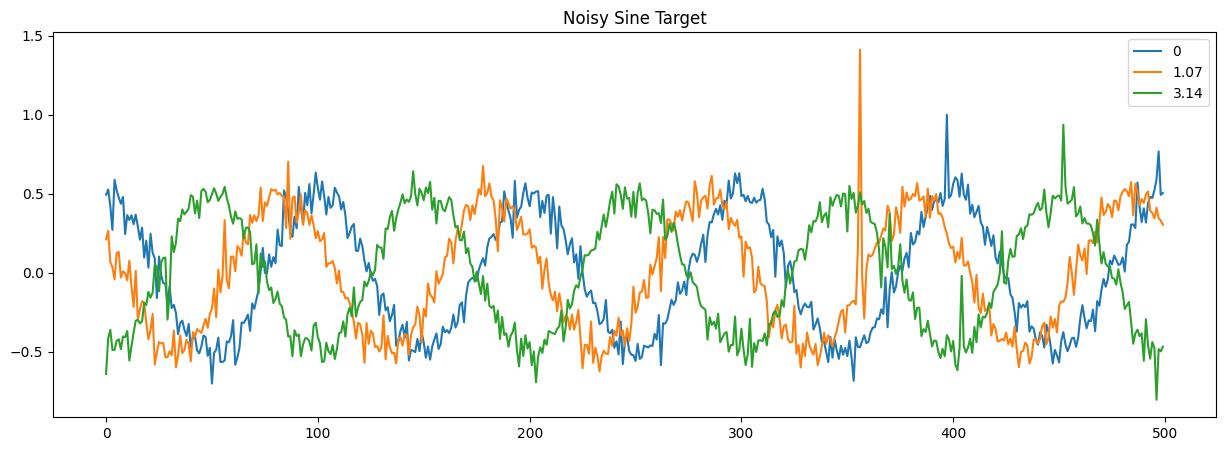

In [3]:
plt.figure(figsize=(15,5))
for phase in [0, 1.07, 3.14]:
    large_wave = WaveGen(size=500).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
    plt.plot(large_wave, label=str(phase))
plt.title('Noisy Sine Target')
plt.legend()
plt.show()

In [31]:
def create_composite_wave(phases, weights, size=5000):
    assert len(phases) == len(weights)
    assert sum(weights) == 1
    waves = list()
    for phase in phases:
        wave = WaveGen(size=size).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
        wave = np.diff(wave)
        waves.append(wave)
    input_wave = np.stack(waves, axis=1)
    target_wave = np.expand_dims(input_wave.dot(weights), axis=1)
    composite_wave = np.concatenate((input_wave, target_wave), axis=1)
    composite_wave = torch.from_numpy(composite_wave)
    return composite_wave

size = 5000
phases = [0.2, 1.07, 1.8, 2.45]
weights = [.1, .25, .35, .3]
composite_wave = create_composite_wave(phases, weights, size=size)

In [45]:
class SimpleDataset(Dataset):
    def __init__(self, Xy):
        self.X = Xy[:,:-1]
        self.y = Xy[:,-1].squeeze()
        return
        
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        X_sample = self.X[idx, :]
        y_sample = self.y[idx]
        return X_sample, y_sample

In [46]:
class LinearRegressor(nnl.LightningModule):
    def __init__(self, input_dim=None, bias=True, criterion=nn.MSELoss):
        super().__init__()
        self.c = criterion
        if input_dim:
            self.linear = nn.Linear(input_dim, 1, bias=bias)
        else:
            self.bias = bias
        return
        
    def forward(self, x):
        if not hasattr(self, 'linear'):
            self.linear = nn.Linear(x.shape[1], 1, bias=self.bias)
        x = self.linear(x)
        if not hasattr(self, 'criterion'):
            self.criterion = self.c(model.parameters())
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, x)
        self.log('val_loss', loss)
        return

In [ ]:
batch_size = 32
train_size = int(size * .8)
test_size = size - train_size - 1

composite_train = composite_wave[:train_size,:]
composite_val = composite_wave[train_size:]

train_loader = DataLoader(SimpleDataset(composite_train), batch_size=batch_size)
val_loader = DataLoader(SimpleDataset(composite_val), batch_size=batch_size)

model = LinearRegressor(input_dim=len(weights)).double()

trainer = nnl.Trainer(precision=16)
trainer.fit(model, train_loader, val_loader)

!tensorboard --logdir .

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5     
----------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


torch.Size([4000, 5])
torch.Size([999, 5])


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([7, 4])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
